In [11]:
using DataFrames, CSV, DelimitedFiles

CODE_ROOT = pwd() * "/../.."

include(CODE_ROOT * "/visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [12]:
function latestfile(dir, filterfunc)
    return filter(filterfunc, readdir(dir, join=true))[end]
end

latestfile (generic function with 1 method)

In [13]:
using Statistics

In [14]:
function juliafortranmeans(nCellsX, jprocs=1024, fprocs=1024)
    fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    # fname *= "2022-08-24T16:27:20.125.txt"
    # fname *= "2022-08-24T16:40:29.640.txt"
    # "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/steps10/2022-06-01T20:17:04.919.txt"
    df = DataFrame(CSV.File(fname))

    runs = [:sim_time2, :sim_time3, :sim_time4, :sim_time5, :sim_time6]
    mpis = [:mpi_time2, :mpi_time3, :mpi_time4, :mpi_time5, :mpi_time6]
    juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
    juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
    juliameans = juliasimmean .+ juliampimean


    fortranfname = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt")
    fortrantiming = readdlm(fortranfname, skipstart=7)
    fortranmeans = fortrantiming[:,end-2] #./ 4
    fortranprocs = fortrantiming[:,1]
    return juliameans, df.procs, fortranmeans, fortranprocs, fname, fortranfname
end

juliafortranmeans (generic function with 3 methods)

In [15]:
function strongscalingplot(juliameans, juliaprocs, fortranmeans, fortranprocs, nCellsX)

    perfectjulia = juliameans[1] * juliaprocs[1] ./ juliaprocs

    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 20

    fig, ax = plt.subplots(figsize=(9,9))
    ax.loglog(juliaprocs, juliameans, label="Julia", linewidth=linewidth,linestyle="-",color="red",marker="s",markersize=markersize)
    ax.loglog(fortranprocs, fortranmeans, label="Fortran", linewidth=linewidth,linestyle="--",color="blue",marker="D",markersize=markersize)
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=21, fontweight="bold")
    ax.legend(loc="upper right", fontsize=labelfontsize)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot (generic function with 1 method)

In [16]:
function strongscalingplot2(julia1, julia2, julia2std, juliaprocs, fortran1, fortran2, fortran2std, fortranprocs, nCellsX)

    perfectjulia = (julia2[1] + julia1[1]) * juliaprocs[1] ./ juliaprocs

    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 20

    fig, ax = plt.subplots(figsize=(9,9))
    ax.loglog(juliaprocs, julia1, label="Julia computation", linewidth=linewidth,linestyle="-",color="red",marker="s",markersize=markersize)
    ax.loglog(fortranprocs, fortran1, label="Fortran computation", linewidth=linewidth,linestyle="-",color="blue",marker="D",markersize=markersize)
    
    ax.errorbar(juliaprocs, julia2, yerr=julia2std, label="Julia communication", linewidth=linewidth,linestyle="--",color="red",marker="P",markersize=markersize)
    ax.errorbar(fortranprocs, fortran2, yerr=fortran2std, label="Fortran communication", linewidth=linewidth,linestyle="--",color="blue",marker="X",markersize=markersize)
    
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=21, fontweight="bold")
    ax.legend(loc="upper right", fontsize=labelfontsize)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot2 (generic function with 1 method)

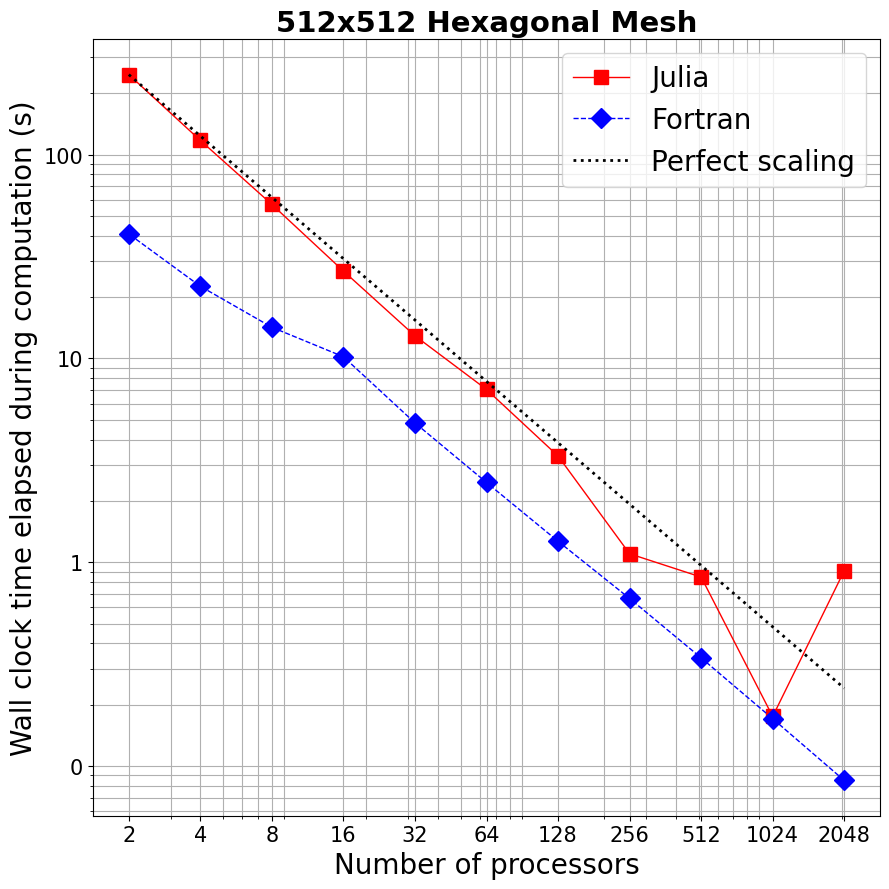

(Figure(PyObject <Figure size 900x900 with 1 Axes>), PyObject <AxesSubplot:title={'center':'512x512 Hexagonal Mesh'}, xlabel='Number of processors', ylabel='Wall clock time elapsed during computation (s)'>)

In [7]:
nCellsX = 512
jt, jp, ft, fp, juliafn, fortranfn = juliafortranmeans(nCellsX, 2048, 2048)
fig, ax = strongscalingplot(jt, jp, ft, fp, nCellsX)
# fig.savefig("$(juliafn)_scaling$(nCellsX)x.png")

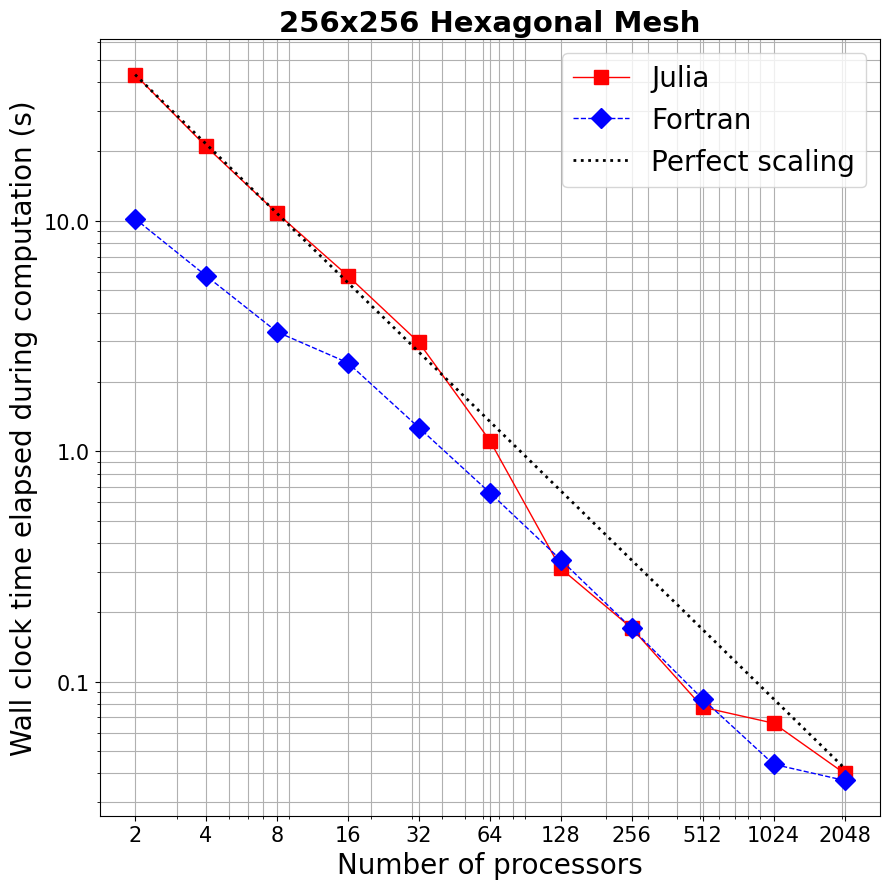

(Figure(PyObject <Figure size 900x900 with 1 Axes>), PyObject <AxesSubplot:title={'center':'256x256 Hexagonal Mesh'}, xlabel='Number of processors', ylabel='Wall clock time elapsed during computation (s)'>)

In [8]:
nCellsX = 256
jt, jp, ft, fp, juliafn, fortranfn = juliafortranmeans(nCellsX, 2048, 2048)
fig, ax = strongscalingplot(jt, jp, ft, fp, nCellsX)
# fig.savefig("$(juliafn)_scaling$(nCellsX)x.png")

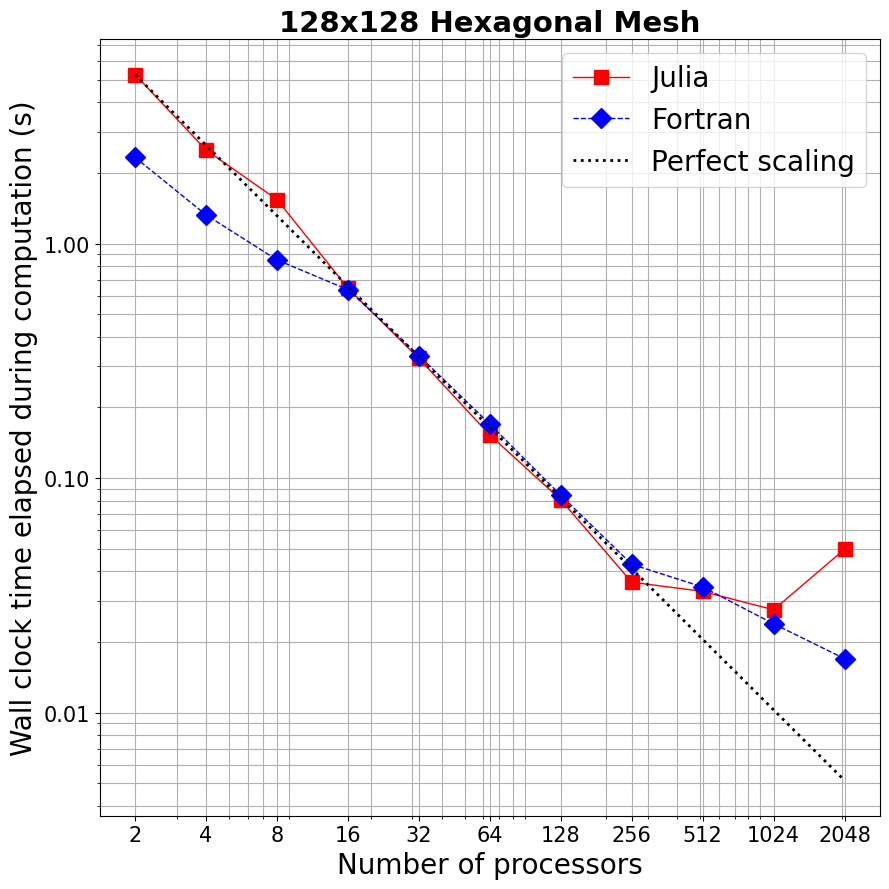

(Figure(PyObject <Figure size 900x900 with 1 Axes>), PyObject <AxesSubplot:title={'center':'128x128 Hexagonal Mesh'}, xlabel='Number of processors', ylabel='Wall clock time elapsed during computation (s)'>)

In [9]:
nCellsX = 128
jt, jp, ft, fp, juliafn, fortranfn = juliafortranmeans(nCellsX, 2048, 2048)
fig, ax = strongscalingplot(jt, jp, ft, fp, nCellsX)
# fig.savefig("$(juliafn)_scaling$(nCellsX)x.png")

In [10]:
# data = juliafortranmeans(256, 1024, 2048)
# fname = data[5]
# fig, ax = strongscalingplot(data[1:4]..., 256)
# fig.savefig("$(fname)_scaling256x.png")

In [17]:
function juliafortrantimesplits(nCellsX, jprocs=1024, fprocs=1024)
    fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    # fname *= "2022-08-24T16:27:20.125.txt"
    # fname *= "2022-08-24T16:40:29.640.txt"
    # "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/steps10/2022-06-01T20:17:04.919.txt"
    df = DataFrame(CSV.File(fname))

    runs = [:sim_time2, :sim_time3, :sim_time4, :sim_time5, :sim_time6] # exclude first number because it may include on-the-fly compile time
    mpis = [:mpi_time2, :mpi_time3, :mpi_time4, :mpi_time5, :mpi_time6]
    juliasimmean = dropdims( 1/length(runs) * sum(Array(df[:,runs]), dims=2), dims=2)
    juliampimean = dropdims( 1/length(mpis) * sum(Array(df[:,mpis]), dims=2), dims=2)
#     juliameans = juliasimmean .+ juliampimean
    juliasimstd = std(Array(df[:,runs]), dims=2)
    juliampistd = std(Array(df[:,runs]), dims=2)


    fortranfname = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt")
    fortrantiming = readdlm(fortranfname, skipstart=7)
    fortrantotalmeans = fortrantiming[:,end-2] #./ 4
    fortranhalos = fortrantiming[:,end]
    fortransimmean = fortrantotalmeans - fortranhalos
    # fortransypd = fortrantiming[:,end] .* 4
    fortranprocs = fortrantiming[:,1]
    # factor = ( fortransypd .* fortranmeans )[1]
    return juliasimmean, juliampimean, df.procs, fortransimmean, fortranhalos, fortranprocs, fname, fortranfname, juliasimstd, juliampistd
end

juliafortrantimesplits (generic function with 3 methods)

In [66]:
function timesplitplot(nprocs, comptime, mpitime, nCellsX, info="")
    fontscale = 2
    
    fig, ax = plt.subplots(1,1, figsize=(length(comptime)*3,8))
#     df = DataFrame(processors=nprocs, computation=comptime, communication=mpitime)
#     df.plot(kind="bar", 
#             stacked=true, 
#             colormap="tab10", 
#             figsize=(10, 6))
    totals = comptime + mpitime
    
    ax.bar(string.(Int.(nprocs)), comptime ./ totals, color="tab:blue", label="Computation")
    ax.bar(string.(Int.(nprocs)), mpitime ./ totals, bottom=comptime ./ totals, color="tab:red", label="Communication")
    
    ax.legend(loc="upper left", fontsize=20*fontscale, bbox_to_anchor=(1,1))
    
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel("Number of processors", fontsize=20*fontscale, labelpad=10.0*fontscale)
    ax.set_ylabel("Proportion of time", fontsize=20*fontscale, labelpad=10.0*fontscale)
    ax.tick_params(axis="x", labelsize=20*fontscale)
    ax.tick_params(axis="y", labelsize=20*fontscale)
    
    # " using $(nCellsX)x$(nCellsX) Hexagonal Mesh"
    ax.set_title("$info: Proportion of Simulation Time Spent on Computation vs Communication", fontweight="bold", fontsize=25*fontscale, y=1.135)
    
#     plt.tick_params(top="off", bottom="off", left="off", right="off", labelleft="off", labelbottom="on")
    
    plt.tight_layout()
    
    return fig, ax
end

timesplitplot (generic function with 2 methods)

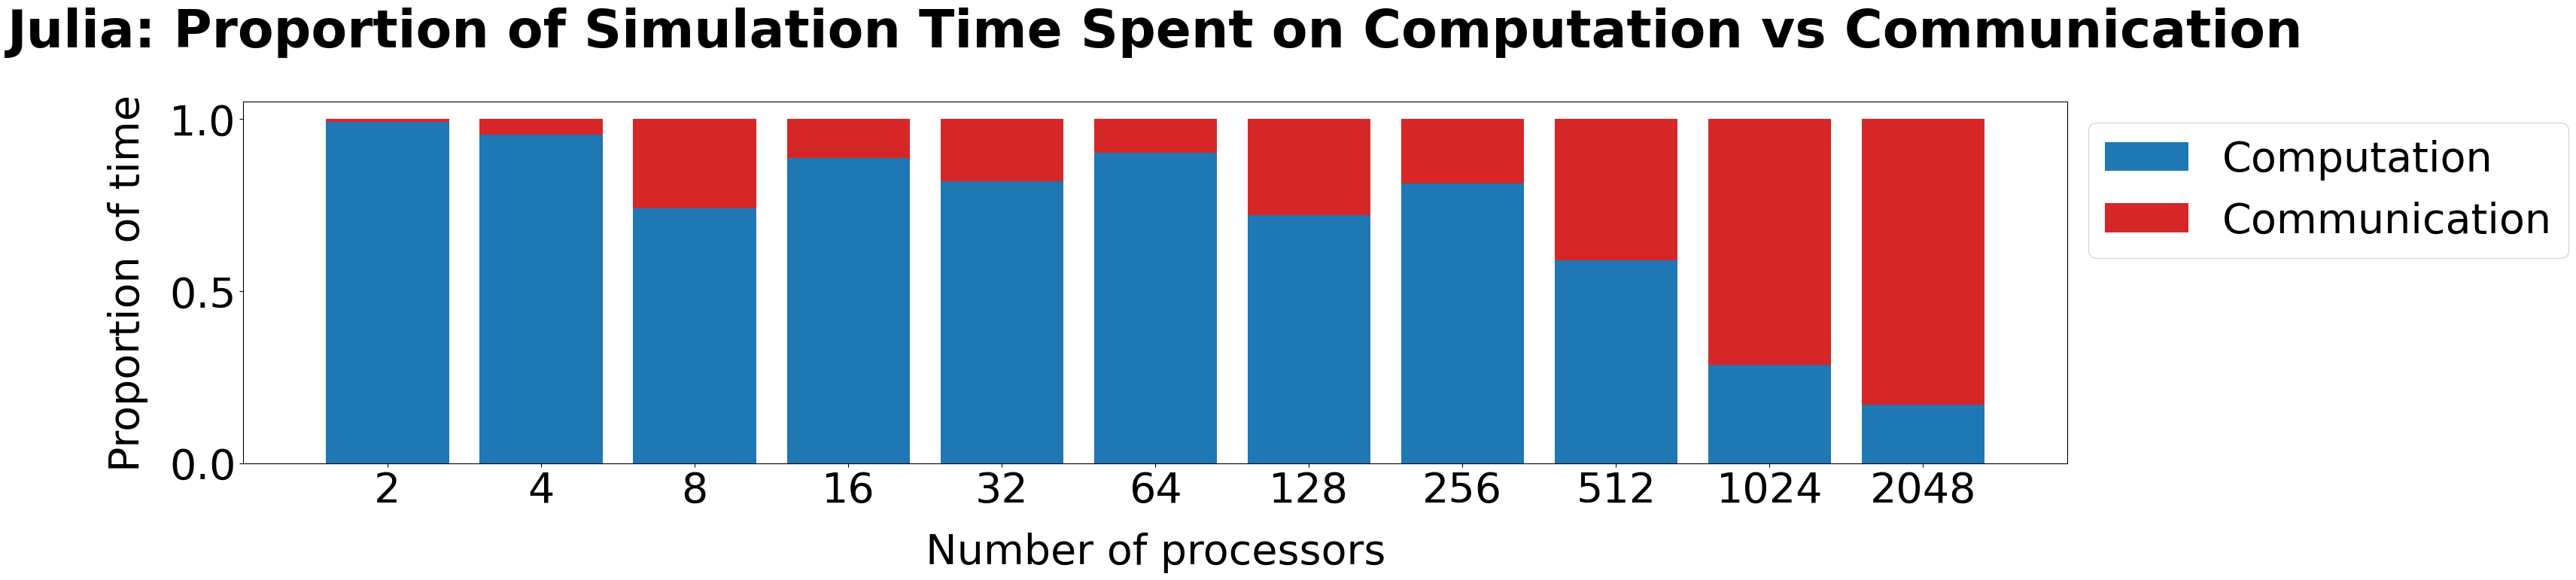

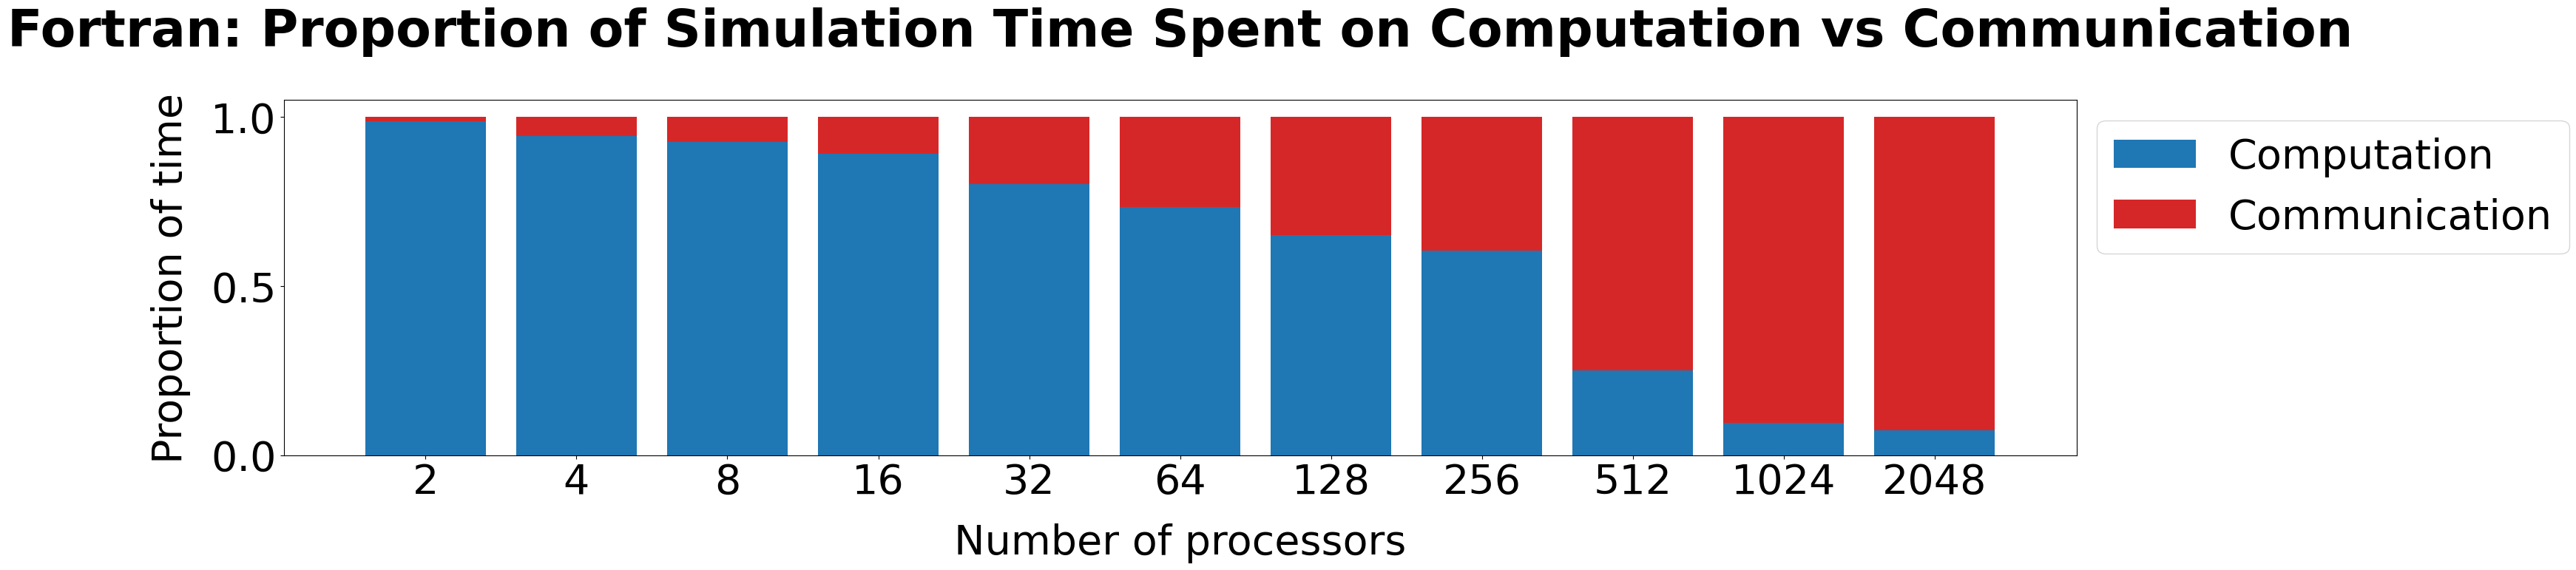

In [67]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd = juliafortrantimesplits(nCellsX, 2048, 2048)

fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig.savefig("$(juliafname)_proportion_sim_mpi.png", bbox_inches="tight")
fig, ax = timesplitplot(fortranprocs[end:-1:1], fortransim[end:-1:1], fortranmpi[end:-1:1], nCellsX, "Fortran")
fig.savefig("$(fortranfname)_proportion_sim_mpi.png", bbox_inches="tight")

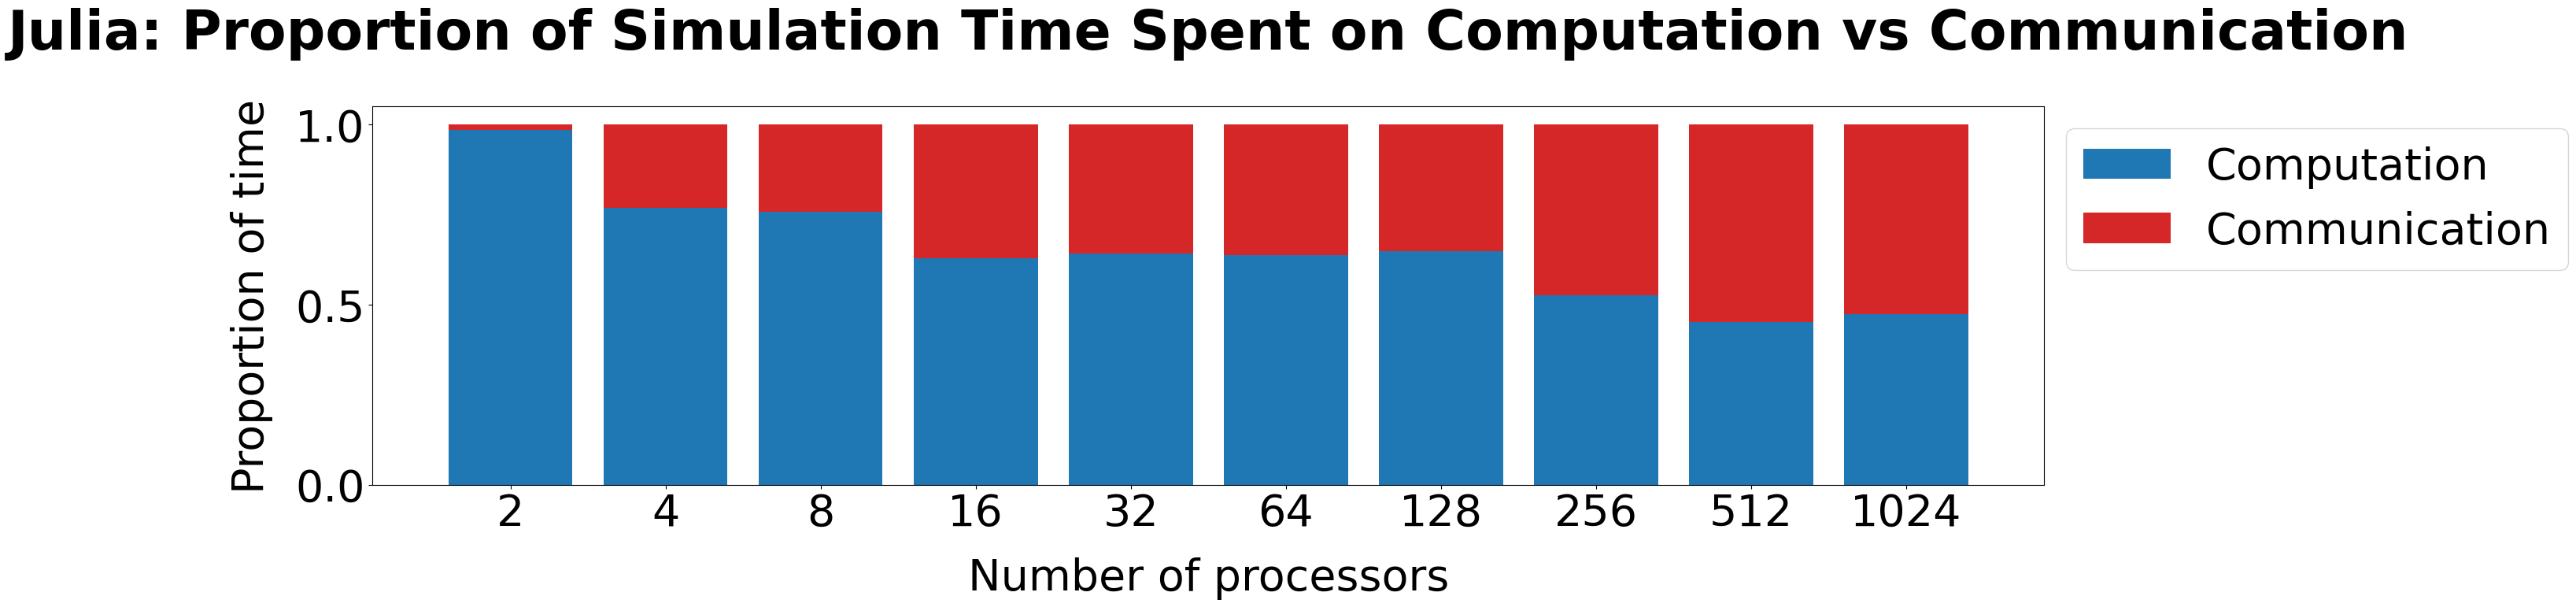

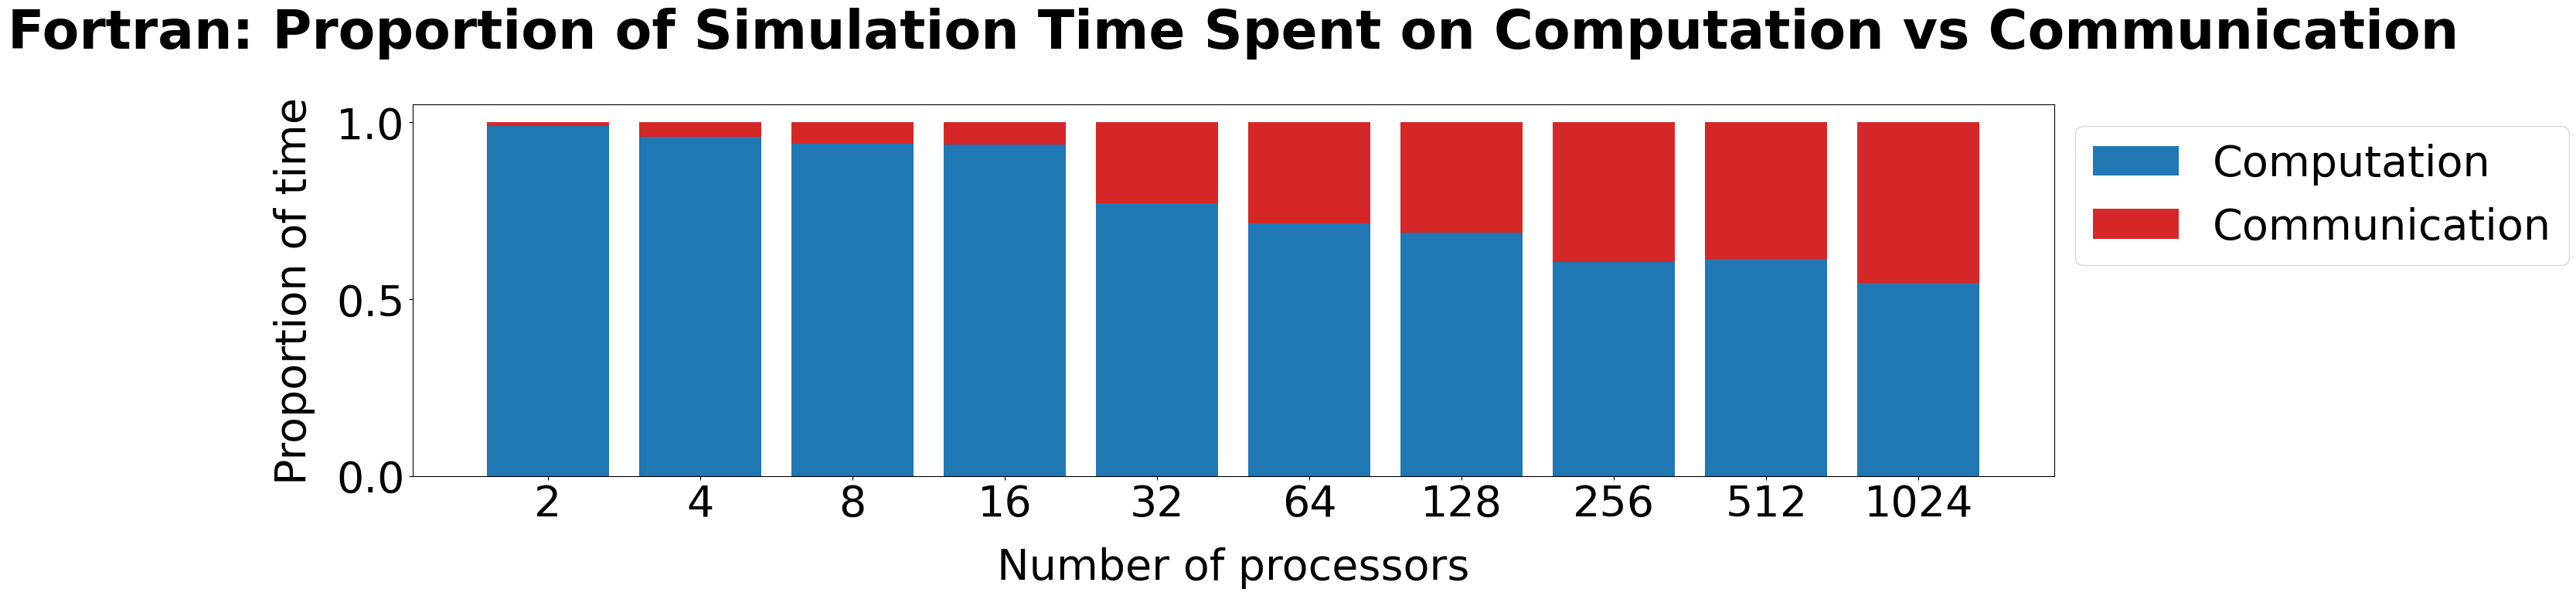

In [61]:
nCellsX = 256
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig.savefig("$(juliafname)_proportion_sim_mpi.png")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
fig.savefig("$(fortranfname)_proportion_sim_mpi.png")

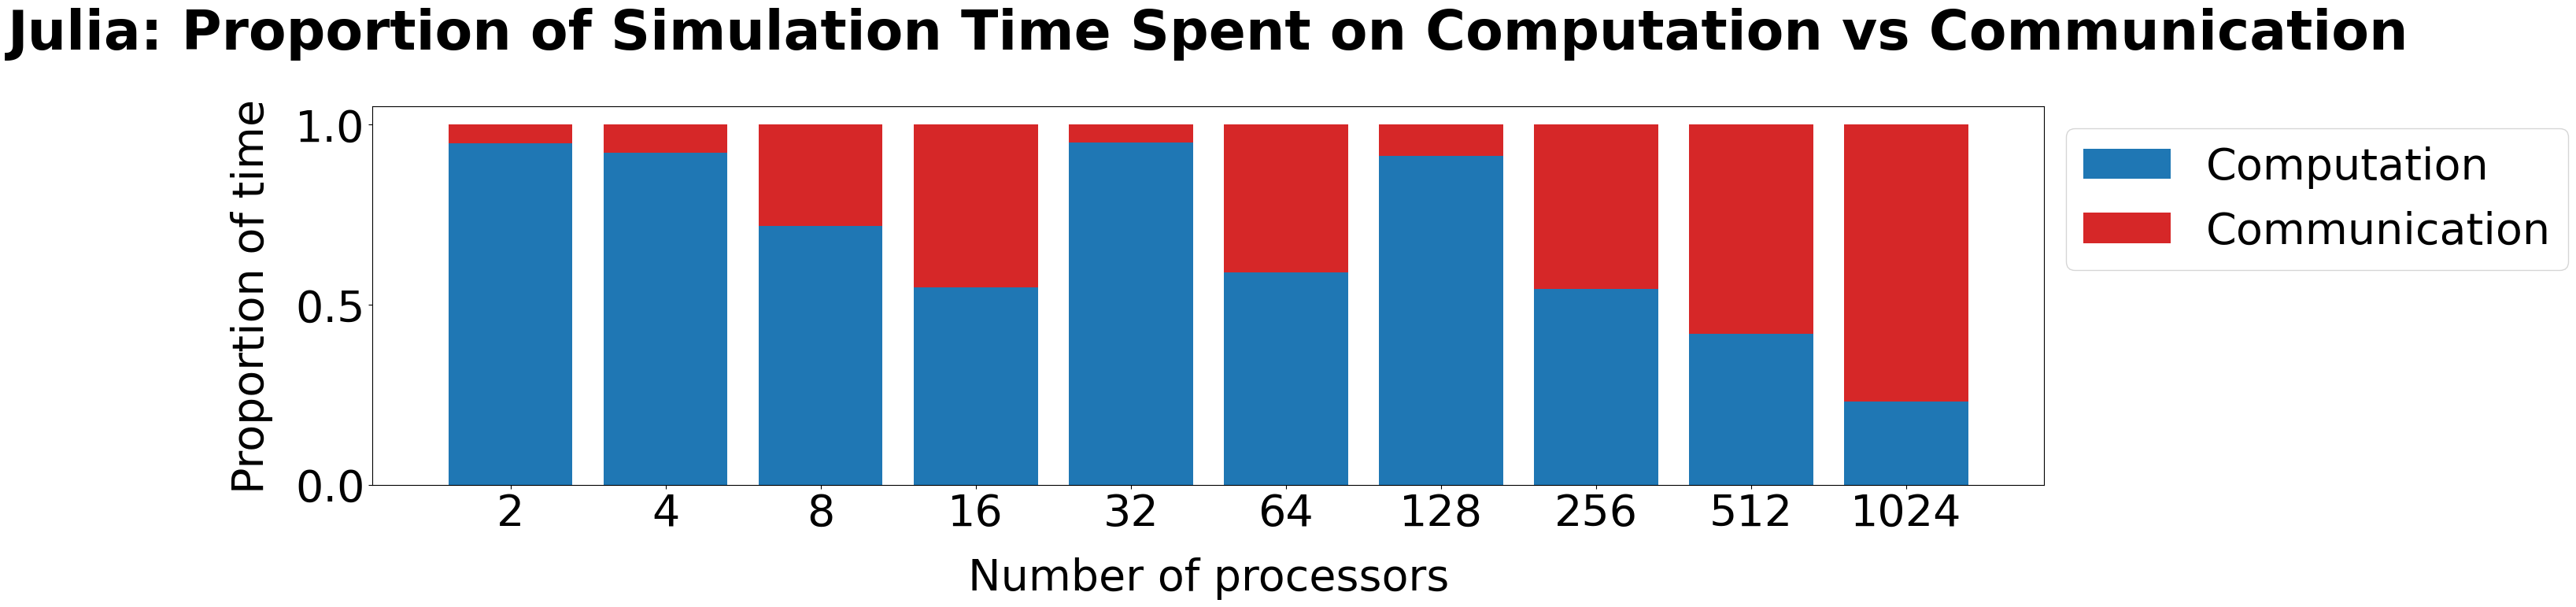

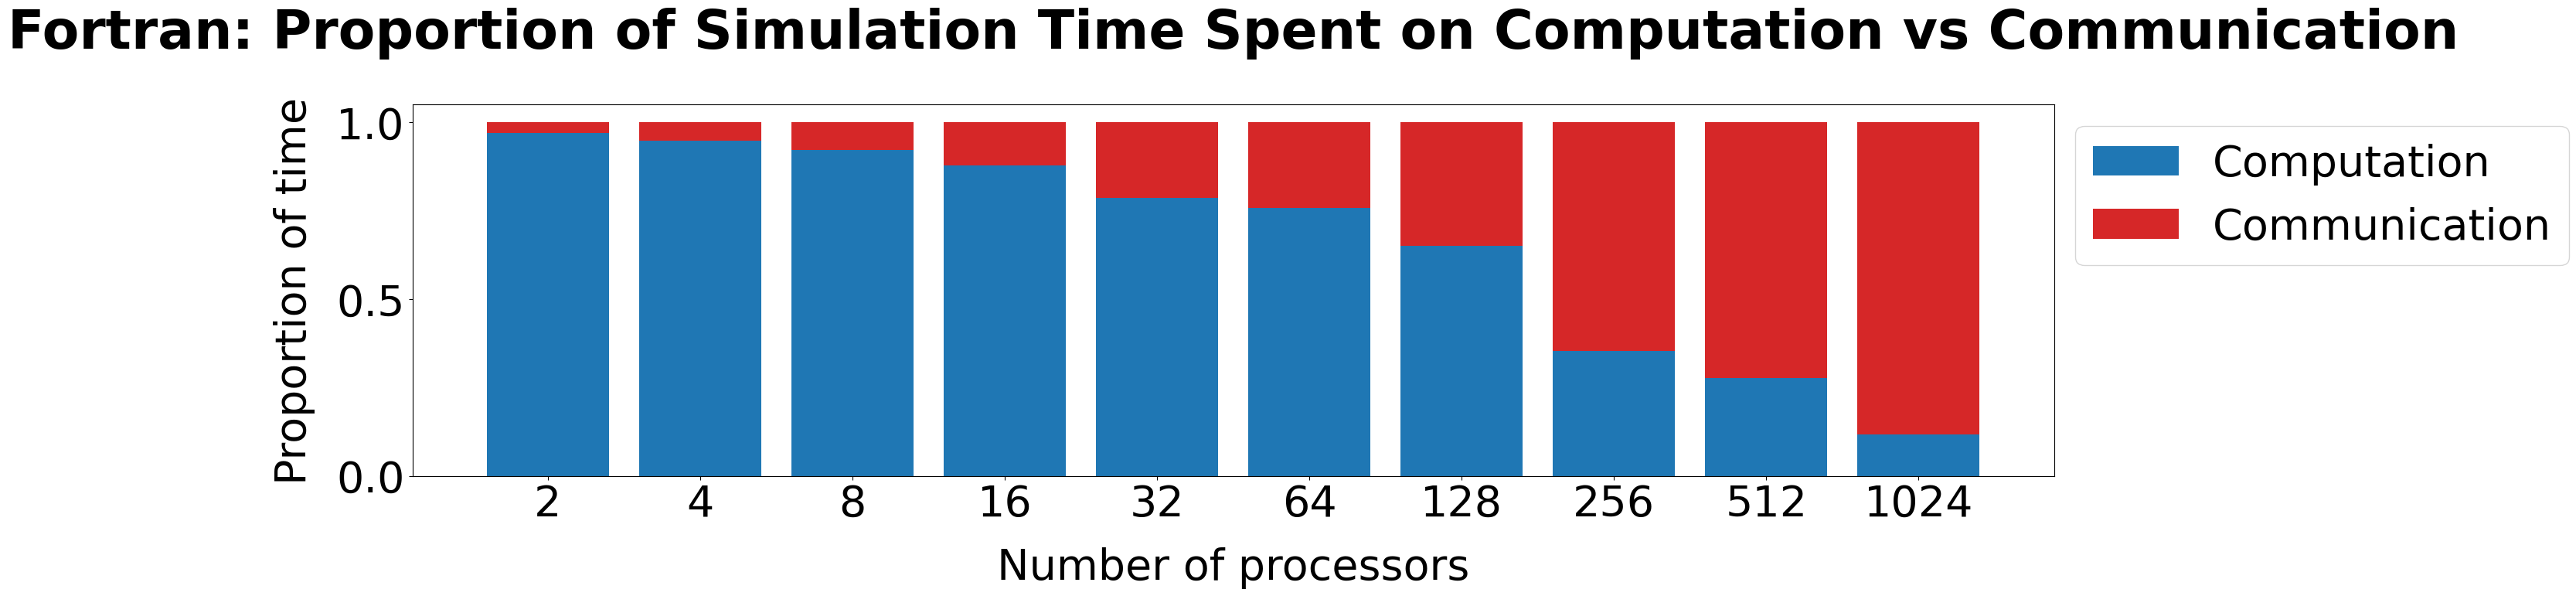

In [59]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig.savefig("$(juliafname)_proportion_sim_mpi.png")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
fig.savefig("$(fortranfname)_proportion_sim_mpi.png")

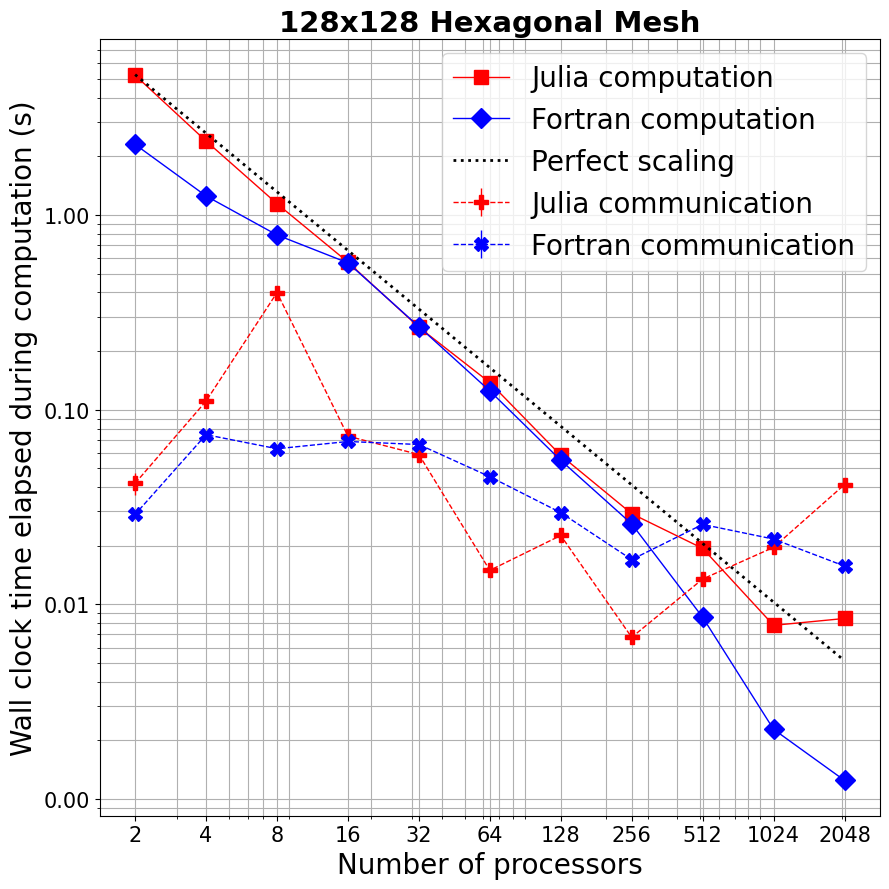

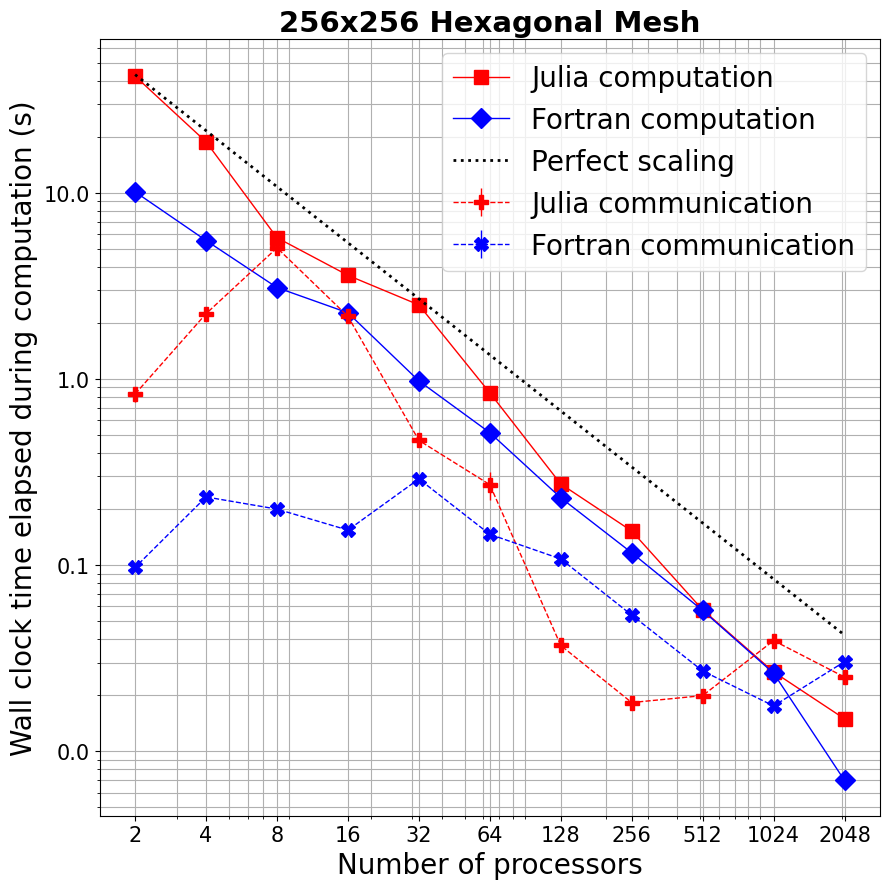

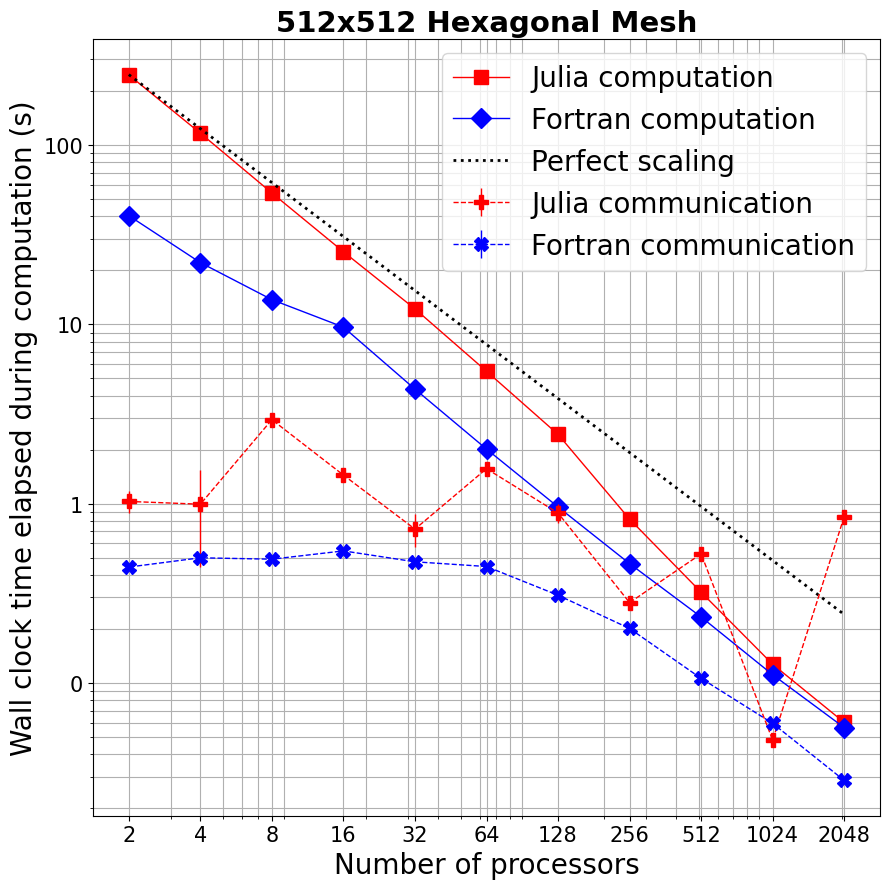

In [57]:
for nCellsX in [128, 256, 512]
    juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd = juliafortrantimesplits(nCellsX, 2048, 2048)

    fig, ax = strongscalingplot2(juliasim, juliampi, dropdims(juliampistd,dims=2), juliaprocs, fortransim, fortranmpi, zeros(length(fortranprocs)), fortranprocs, nCellsX)
    # fig.text(0.5, 1, "Computation only")
#     fig.savefig("$(juliafname)_scaling_$(nCellsX)x_sim_and_mpi.png", bbox_inches="tight")
end

In [ ]:
function weakscalingplot()
    resolutions = [128, 256, 512]
    cellsperproclines = [64^2, 64^2 /2, 64^2/4]
    juliatimes = zeros((length(resolutions),length(cellsperproclines)))
    fortrantimes = zeros((length(resolutions),length(cellsperproclines)))
    fnames = Vector{String}(undef, 4)

    for (i, nCellsX) in enumerate(resolutions)
        juliameans, juliaprocs, fortranmeans, fortranprocs, fnames[i] = juliafortranmeans(nCellsX)

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ juliaprocs)
        juliatimes[i,:] = juliameans[ind]

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ fortranprocs)
        fortrantimes[i,:] = fortranmeans[ind]
    end

    fig, ax = plt.subplots(1,1, figsize=(9,9))

    julialines = ax.loglog(resolutions, juliatimes)
    fortranlines = ax.loglog(resolutions, fortrantimes, linestyle="--")
    ax.set_xlabel("Number of cells (X)")
    ax.set_ylabel("Wallclock time elapsed during computation")
    ax.legend(julialines, cellsperproclines, title="cells per process (julia)", loc="upper left")
    ax.legend(fortranlines, cellsperproclines, title="cells per process (fortran)", loc="upper right")

    display(fig)

    return fig
end

weakscalingplot()





# fig.savefig("/tmp/plot.png")